In [ ]:
from load_modules import *
import csv
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colorspacious
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
#set memory amount to half of GPU

if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")
# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))
# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [19]:
image_folder = r"models_4k"
image_paths = os.listdir(image_folder)
images = []
names = []
for image_path in image_paths:
    folder_name = image_path.split('.')[0]
    names.append(folder_name)
    image_path = os.path.join(image_folder, image_path)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
print(names)
all_model_paths = []
model_path = r"TrainedModels\316"
encoder_path = os.path.join(model_path, "encoder.h5")
decoder_path = os.path.join(model_path, "decoder.h5")
encoder = tf.keras.models.load_model(encoder_path)
decoder = tf.keras.models.load_model(decoder_path)
encoder_paths = []
decoder_paths = []
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']


shape of pred_maps: (16777216, 5)
Cm min: -0.12033899128437042 Cm mean: -0.03945447504520416| Cm max: 0.6048187613487244 | Ch min: 0.019863318651914597 Ch mean: 0.07274745404720306| Ch max: 0.26485392451286316 | T min: 0.11884630471467972 T mean: 0.25358089804649353| T max: 0.2948349118232727 | Bm min: 0.4372950792312622 Bm mean: 0.4672556519508362| Bm max: 0.5214961767196655 | Bh min: 0.3536853790283203 Bh mean: 0.4932069182395935| Bh max: 0.7057725191116333
shape of recovered: (16777216, 3)


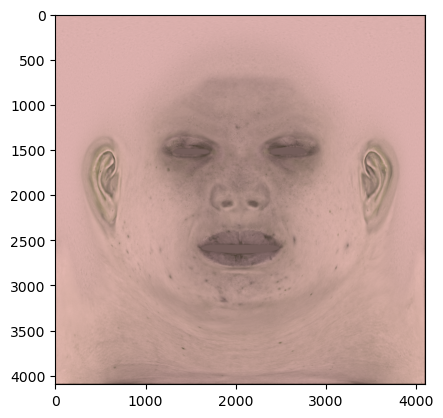

size of image: (4096, 4096, 3)
max pixel value: 0.9406850337982178
min pixel value: 0.08775613456964493
shape of pred_maps: (16777216, 5)
Cm min: 0.033463288098573685 Cm mean: 0.16528354585170746| Cm max: 0.6082751750946045 | Ch min: 0.0914304107427597 Ch mean: 0.13963480293750763| Ch max: 0.2609216570854187 | T min: 0.11520218104124069 T mean: 0.20235851407051086| T max: 0.23733200132846832 | Bm min: 0.4475538730621338 Bm mean: 0.46694934368133545| Bm max: 0.5535010099411011 | Bh min: 0.34195780754089355 Bh mean: 0.5367228984832764| Bh max: 0.6924225687980652
shape of recovered: (16777216, 3)


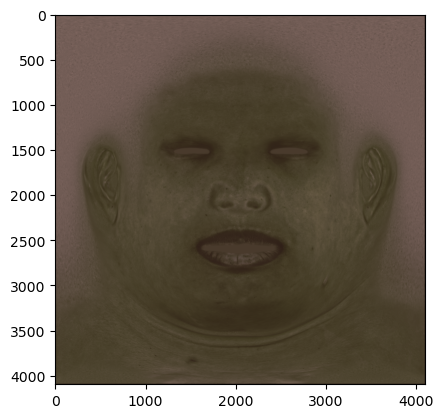

size of image: (4096, 4096, 3)
max pixel value: 0.5957490801811218
min pixel value: 0.0877481997013092
shape of pred_maps: (16777216, 5)
Cm min: -0.06582620739936829 Cm mean: 0.03668559715151787| Cm max: 0.6065470576286316 | Ch min: 0.008262671530246735 Ch mean: 0.0817338228225708| Ch max: 0.25555887818336487 | T min: 0.11766653507947922 T mean: 0.24845759570598602| T max: 0.3081355392932892 | Bm min: 0.4384395480155945 Bm mean: 0.4616990387439728| Bm max: 0.5287182927131653 | Bh min: 0.34930703043937683 Bh mean: 0.5480659604072571| Bh max: 0.7298310995101929
shape of recovered: (16777216, 3)


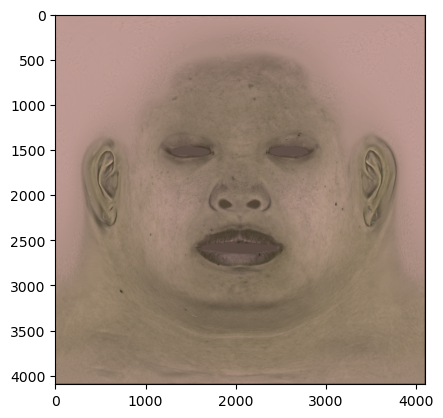

size of image: (4096, 4096, 3)
max pixel value: 0.8340380191802979
min pixel value: 0.08779283612966537
shape of pred_maps: (16777216, 5)
Cm min: -0.018970008939504623 Cm mean: 0.3336601257324219| Cm max: 0.605862557888031 | Ch min: 0.11351734399795532 Ch mean: 0.19761061668395996| Ch max: 0.27182018756866455 | T min: 0.11884630471467972 T mean: 0.17639140784740448| T max: 0.22262898087501526 | Bm min: 0.45514991879463196 Bm mean: 0.5027583241462708| Bm max: 0.5416910648345947 | Bh min: 0.3536853790283203 Bh mean: 0.5085182785987854| Bh max: 0.6169816255569458
shape of recovered: (16777216, 3)


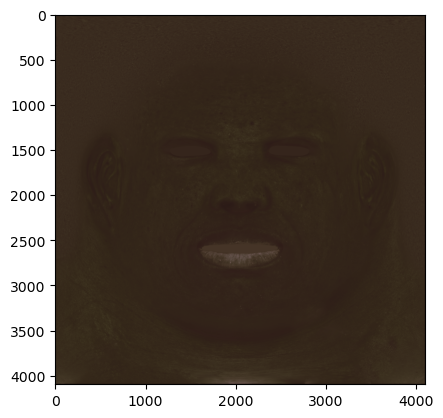

size of image: (4096, 4096, 3)
max pixel value: 0.6680722832679749
min pixel value: 0.08754277229309082
shape of pred_maps: (16777216, 5)
Cm min: 0.01697242632508278 Cm mean: 0.49287623167037964| Cm max: 0.6065470576286316 | Ch min: 0.13492953777313232 Ch mean: 0.2543758451938629| Ch max: 0.2754439413547516 | T min: 0.11794907599687576 T mean: 0.14623196423053741| T max: 0.1932644546031952 | Bm min: 0.4418247938156128 Bm mean: 0.5230117440223694| Bm max: 0.5455486178398132 | Bh min: 0.33234885334968567 Bh mean: 0.41791656613349915| Bh max: 0.5345053672790527
shape of recovered: (16777216, 3)


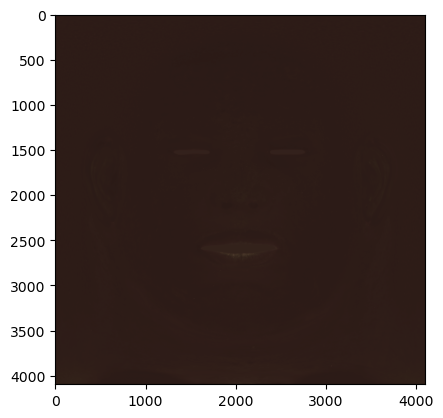

size of image: (4096, 4096, 3)
max pixel value: 0.6010172367095947
min pixel value: 0.087559774518013


In [28]:

# fig,ax = plt.subplots(5,5, figsize=(16,14))
subjects_meta = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
idx = 0
for image, folder_name in zip(images, names):
    WIDTH = image.shape[0]
    HEIGHT = image.shape[1]
    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    pred_maps, encode_time = encode(image_numpy)
    print(f"shape of pred_maps: {pred_maps.shape}")
    Cm = np.asarray(pred_maps[:,0])
    Ch = np.asarray(pred_maps[:,1])
    Bm = np.asarray(pred_maps[:,2])
    Bh = np.asarray(pred_maps[:,3])
    T = np.asarray(pred_maps[:,4])
    av_T = np.mean(T)
    max_T = np.max(T)
    min_T = np.min(T)
    av_Cm = np.mean(Cm)
    max_Cm = np.max(Cm)
    min_Cm = np.min(Cm)
    av_Ch = np.mean(Ch)
    max_Ch = np.max(Ch)
    min_Ch = np.min(Ch)
    min_Bm = np.min(Bm)
    max_Bm = np.max(Bm)
    av_Bm = np.mean(Bm)
    min_Bh = np.min(Bh)
    max_Bh = np.max(Bh)
    av_Bh = np.mean(Bh)
    # result_string = f"Cm: {av_Cm}, {max_Cm}, {min_Cm} | Ch: {av_Ch}, {max_Ch}, {min_Ch} | T: {av_T}, {max_T}, {min_T} | delta_e: {av_delta_e}, {max_delta_e}, {min_delta_e}"
    result_string = f"Cm min: {min_Cm} Cm mean: {av_Cm}| Cm max: {max_Cm} | Ch min: {min_Ch} Ch mean: {av_Ch}| Ch max: {max_Ch} | T min: {min_T} T mean: {av_T}| T max: {max_T} | Bm min: {min_Bm} Bm mean: {av_Bm}| Bm max: {max_Bm} | Bh min: {min_Bh} Bh mean: {av_Bh}| Bh max: {max_Bh}"
    print(result_string)
    pred_maps[:,0] = Cm
    pred_maps[:,1] = Ch
    pred_maps[:,2] = Bm
    pred_maps[:,3] = Bh*0
    pred_maps[:,4] = T
    recovered, decode_time = decode(pred_maps)
    print(f"shape of recovered: {recovered.shape}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    # recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')

    # recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
    plt.imshow(recovered)
    plt.show()
    #save the image 
    #print size of image
    print(f"size of image: {recovered.shape}")
    #max min pixel values
    print(f"max pixel value: {np.max(recovered)}")
    print(f"min pixel value: {np.min(recovered)}")
    #clamp the values to 0-1
    recovered = np.clip(recovered, 0, 1)
    file_NAME = f"zbh_{subjects_meta[idx]}.png"
    plt.imsave(file_NAME, recovered)
    idx += 1
    